# IELTS Essay Scoring Model Evaluation

This notebook evaluates and calibrates our IELTS essay scoring model, analyzing its performance and generating insights for the research paper.

## Key Objectives:
1. Calibrate model predictions to valid IELTS band range (0-9)
2. Calculate model accuracy metrics (MAE, R²)
3. Visualize prediction performance
4. Test adaptive feedback mechanism

In [4]:
# Cell 1 - imports & config
import os
import re
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
import sentencepiece as spm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix
from scipy import stats
from tqdm import tqdm
from datasets import load_dataset
import pandas as pd

ds = load_dataset("chillies/IELTS-writing-task-2-evaluation")
df_test = pd.DataFrame(ds["test"])

print(df_test.columns)
print(df_test.head(1))

# Adjust paths
project_root = "/home/mastermind/ielts_pred"
SPM_MODEL = os.path.join(project_root, "tokenizer", "spm.model")
model_path = "src/model/ielts_improved_model.pt"
data_path = ds

MAX_SEQ_LEN = 200
EMBEDDING_DIM = 200
BATCH_SIZE = 64
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)


Index(['prompt', 'essay', 'evaluation', 'band'], dtype='object')
                                              prompt  \
0  Interview form the basic selection criteria fo...   

                                               essay  \
0  To agree or disagree with the statement that i...   

                                          evaluation  \
0  **Task Achievement (6.5)**\n- The essay effect...   

                                      band  
0  6.5\n\n\n\n\n\r\r\r\r\r\r\r\r\r\r\r\r\r  
Device: cuda


In [18]:
# Full pipeline: load HF dataset -> convert -> rename/clean -> prepare tensors -> evaluate model
import re
import torch
import numpy as np
import pandas as pd
from datasets import load_dataset
from torch.utils.data import DataLoader, TensorDataset
import sentencepiece as spm
from sklearn.metrics import mean_absolute_error, r2_score

# CONFIG (edit if needed)
HF_NAME = "chillies/IELTS-writing-task-2-evaluation"
SPLIT = "train"            # choose 'train'/'test' as available
SPM_MODEL = "/home/mastermind/ielts_pred/tokenizer/spm.model"
model_path = "src/model/ielts_improved_model.pt"
MAX_SEQ_LEN = 200
BATCH_SIZE = 64
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 1) Load HF dataset split
ds = load_dataset(HF_NAME)
if SPLIT not in ds:
    # fallback to 'train'
    SPLIT = "train"
df = pd.DataFrame(ds[SPLIT])
print("Loaded HF split, columns:", df.columns.tolist())
print(df.head(1).to_dict(orient='records')[0])

# 2) Clean and rename columns to what your pipeline expects:
#    your pipeline expected: 'Essay' and 'Overall' (and you compute 'Scaled' = Overall/9)
#    HF dataset has: 'essay' and 'band' (strings with noise). We'll map them.

def extract_numeric_band(b):
    if pd.isna(b):
        return np.nan
    # b might be like "6.5\n\n\r\r\r" etc. Extract numeric pattern.
    s = str(b)
    m = re.search(r'(\d+(?:\.\d+)?)', s)
    return float(m.group(1)) if m else np.nan

# Create DataFrame with the expected column names
converted = pd.DataFrame()
converted['Essay'] = df['essay'].astype(str)
converted['Overall'] = df['band'].apply(extract_numeric_band)   # float scores
converted = converted.dropna(subset=['Essay', 'Overall']).reset_index(drop=True)

# Add Scaled column (0-1 range)
converted['Scaled'] = converted['Overall'] / 9.0

print("Converted DF shape:", converted.shape)
print("Score range:", converted['Overall'].min(), converted['Overall'].max())

# 3) If you want to use your prepare_data() which expects the 'Essay', 'Overall', 'Scaled' columns:
#    (import prepare_data if available) OR proceed directly to encode & evaluate.
# from src.utils.data import prepare_data
# train_df, val_df = prepare_data(converted, test_size=0.15)   # optional

# 4) Load SentencePiece tokenizer
sp = spm.SentencePieceProcessor()
sp.load(SPM_MODEL)

def encode_essay_spm(text, max_len=MAX_SEQ_LEN):
    ids = sp.encode(text, out_type=int)
    if len(ids) > max_len:
        ids = ids[:max_len]
    else:
        ids = ids + [0] * (max_len - len(ids))
    return ids

# 5) Build X and y tensors
essays = converted['Essay'].astype(str).tolist()
X = np.array([encode_essay_spm(t, MAX_SEQ_LEN) for t in essays], dtype=np.int64)
y = converted['Overall'].astype(float).values.astype(np.float32)

X_tensor = torch.from_numpy(X)   # shape (N, MAX_SEQ_LEN)
y_tensor = torch.from_numpy(y)

# 6) DataLoader
test_dataset = TensorDataset(X_tensor, y_tensor)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 7) Load your model (use the exact code you already have)
from src.model.transformer import IELTSTransformerWithFeatures
checkpoint = torch.load(model_path, map_location=device)
vocab_size = checkpoint['vocab_size']

model = IELTSTransformerWithFeatures(
    vocab_size=vocab_size,
    d_model=EMBEDDING_DIM,
    nhead=4,
    num_layers=3,
    max_len=MAX_SEQ_LEN,
    dropout=0.2
).to(device)

model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print("Model loaded. Params:", sum(p.numel() for p in model.parameters()))

def compute_features(df, num_features=10):
    """Compute numeric features expected by IELTSTransformerWithFeatures."""
    feats = []
    for essay in df['Essay']:
        essay = essay.strip()
        words = essay.split()
        n_words = len(words)
        n_chars = len(essay)
        avg_word_len = np.mean([len(w) for w in words]) if words else 0
        n_sents = max(1, essay.count('.') + essay.count('!') + essay.count('?'))
        words_per_sent = n_words / n_sents
        lexical_diversity = len(set(words)) / n_words if n_words > 0 else 0
        # add more features if you have them (pad to num_features)
        feats.append([n_words, n_chars, avg_word_len, n_sents, words_per_sent, lexical_diversity])
    feats = np.array(feats, dtype=np.float32)
    # pad to num_features
    if feats.shape[1] < num_features:
        pad = np.zeros((feats.shape[0], num_features - feats.shape[1]), dtype=np.float32)
        feats = np.concatenate([feats, pad], axis=1)
    return torch.tensor(feats)

# Precompute features
X_features = compute_features(converted).to(device)

preds = []
trues = []

with torch.no_grad():
    for i in range(0, len(X_tensor), BATCH_SIZE):
        xb = X_tensor[i:i+BATCH_SIZE].to(device)
        feats_batch = X_features[i:i+BATCH_SIZE]
        yb = y_tensor[i:i+BATCH_SIZE].to(device)
        
        out = model(xb, feats_batch)  # pass features
        out = out.squeeze()
        
        preds.extend(out.cpu().numpy())
        trues.extend(yb.cpu().numpy())

preds = np.array(preds)
trues = np.array(trues)

mae = mean_absolute_error(trues, preds)
r2 = r2_score(trues, preds)
print(f"Eval on HF {SPLIT} split: MAE={mae:.3f}, R2={r2:.3f}")

# 9) Save predictions
converted['predicted'] = preds
converted.to_csv("predictions_hf_converted.csv", index=False)
print("Saved predictions_hf_converted.csv")


Loaded HF split, columns: ['prompt', 'essay', 'evaluation', 'band']
{'prompt': 'Interviews form the basic criteria for most large companies. However, some people think that the interview is not a reliable method of choosing whom to employ and there are other better methods. To what extent do you agree or disagree?', 'essay': 'It is believed by some experts that the traditional approach of recruiting candidates which is interviewing is the best way, whereas others think different methods such as exams writing, CVs, cover letters or application letters and many more are good. I strongly agree with the statement, "interview is the most reliable approach to recruit workers" because this method assists the recruiters to know the person and his ability to do the work and their problem-solving abilities. \n\nTo begin with, an interview enables the  recruiter to know the kind of person he or she is recruiting. It helps the employer to see the personality traits of the employee such as how he a

## Load and Prepare Data

Let's load our IELTS dataset and prepare it for evaluation. We'll also initialize our model with the trained weights.

In [10]:
# Cell 2 - helpers (must match training!)
def extract_linguistic_features(essay):
    words = essay.split()
    sentences = re.split(r'[.!?]+', essay)
    sentences = [s.strip() for s in sentences if s.strip()]
    features = []
    features.append(len(words))
    features.append(len(sentences) if sentences else 1)
    features.append(len(words) / max(len(sentences), 1))
    unique_words = len(set(w.lower() for w in words))
    features.append(unique_words / max(len(words), 1))
    features.append(len(essay))
    features.append(sum(1 for c in essay if c.isupper()) / max(len(essay), 1))
    features.append(essay.count(',') / max(len(words), 1))
    features.append(essay.count('.') / max(len(sentences), 1))
    avg_word_len = sum(len(w) for w in words) / max(len(words), 1)
    features.append(avg_word_len)
    transition_words = {
        'however', 'moreover', 'furthermore', 'therefore', 'consequently',
        'nevertheless', 'additionally', 'specifically', 'particularly', 'especially'
    }
    transition_count = sum(1 for w in words if w.lower() in transition_words)
    features.append(transition_count / max(len(words), 1))
    return np.array(features, dtype='float32')

def tokenise_spm_with_mask(essays, max_len=MAX_SEQ_LEN):
    sp = spm.SentencePieceProcessor(model_file=SPM_MODEL)
    encoded, masks = [], []
    for e in essays:
        ids = sp.encode(e, out_type=int)[:max_len]
        mask = [1]*len(ids) + [0]*(max_len - len(ids))
        padded = ids + [0]*(max_len - len(ids))
        encoded.append(padded)
        masks.append(mask)
    return torch.tensor(encoded, dtype=torch.long), torch.tensor(masks, dtype=torch.long)


## Implement Prediction Function with Calibration

Now we'll create a function that makes predictions and ensures they stay within the valid IELTS band range (0-9).

In [9]:
# Cell 3 - load and split (NO AUGMENTATION for fair test)
from sklearn.model_selection import train_test_split
from src.utils.data import load_dataset, prepare_data
df = load_dataset(data_path)

# IMPORTANT: create a held-out test / validation using augment=False
train_df, val_df = train_test_split(
    df,
    test_size=0.15,
    random_state=42,
    shuffle=True
)

print("Train / Val sizes:", len(train_df), len(val_df))
print(val_df['Overall'].value_counts().sort_index())


ValueError: Invalid file path or buffer object type: <class 'datasets.dataset_dict.DatasetDict'>

In [11]:
from sklearn.model_selection import train_test_split
from datasets import load_dataset
import pandas as pd
import re
import numpy as np

# 1) Load HF dataset
ds = load_dataset("chillies/IELTS-writing-task-2-evaluation")
df = pd.DataFrame(ds['train'])  # or ds['test']

# 2) Convert columns to match your pipeline
def extract_numeric_band(b):
    if pd.isna(b):
        return np.nan
    s = str(b)
    m = re.search(r'(\d+(?:\.\d+)?)', s)
    return float(m.group(1)) if m else np.nan

converted = pd.DataFrame()
converted['Essay'] = df['essay'].astype(str)
converted['Overall'] = df['band'].apply(extract_numeric_band)
converted = converted.dropna(subset=['Essay', 'Overall']).reset_index(drop=True)
converted['Scaled'] = converted['Overall'] / 9.0

# 3) Split for validation
train_df, val_df = train_test_split(
    converted,
    test_size=0.15,
    random_state=42,
    shuffle=True
)

print("Train / Val sizes:", len(train_df), len(val_df))
print(val_df['Overall'].value_counts().sort_index())


Train / Val sizes: 8358 1475
Overall
4.0    171
4.5    103
5.0    142
5.5    157
6.0    171
6.5    182
7.0    203
7.5    154
8.0    118
8.5     60
9.0     14
Name: count, dtype: int64


## Evaluate Model Performance

Let's calculate key metrics (MAE, R²) and create visualizations to assess model performance.

In [12]:
# Cell 4 - tokenization & features for val set
X_val, X_val_mask = tokenise_spm_with_mask(val_df['Essay'].values)
val_features = np.array([extract_linguistic_features(e) for e in val_df['Essay'].values])

feat_mean = np.load(os.path.join(project_root, "features_mean.npy"))
feat_std  = np.load(os.path.join(project_root, "features_std.npy"))
X_val_feat = torch.tensor((val_features - feat_mean) / feat_std, dtype=torch.float32)

y_val_scaled = torch.tensor(val_df['Scaled'].values, dtype=torch.float32)
y_val_ielts = val_df['Overall'].values

print("X_val shape:", X_val.shape, "feat shape:", X_val_feat.shape)
val_dataset = TensorDataset(X_val, X_val_mask, X_val_feat, y_val_scaled)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

X_val shape: torch.Size([1475, 200]) feat shape: torch.Size([1475, 10])


## Visualize Results

Create scatter plots and comparison tables to visualize model performance.

In [13]:
# Cell 5 - load model
from src.model.transformer import IELTSTransformerWithFeatures

checkpoint = torch.load(model_path, map_location=device)
vocab_size = checkpoint['vocab_size']

model = IELTSTransformerWithFeatures(
    vocab_size=vocab_size, d_model=EMBEDDING_DIM, nhead=4, num_layers=3, max_len=MAX_SEQ_LEN, dropout=0.2
).to(device)

model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print("Model loaded. Params:", sum(p.numel() for p in model.parameters()))

Model loaded. Params: 3020779


## Test Adaptive Feedback System

Let's test the feedback system with a sample essay, apply the suggested improvements, and measure the score change.

In [14]:
# Cell 6 - predict + core metrics
y_pred_scaled = []
y_true_scaled = []

with torch.no_grad():
    for xb, mask, feat, yb in val_loader:
        xb = xb.to(device); mask = mask.to(device); feat = feat.to(device)
        preds = model(xb, feat, mask).squeeze().cpu().numpy()
        y_pred_scaled.extend(preds)
        y_true_scaled.extend(yb.numpy())

y_pred_scaled = np.clip(np.array(y_pred_scaled), 0, 1)
y_true_scaled = np.array(y_true_scaled)
y_pred_ielts = y_pred_scaled * 9
y_true_ielts = y_val_ielts

mae = mean_absolute_error(y_true_ielts, y_pred_ielts)
rmse = np.sqrt(mean_squared_error(y_true_ielts, y_pred_ielts))
r2 = r2_score(y_true_ielts, y_pred_ielts)
pearson, _ = stats.pearsonr(y_true_ielts, y_pred_ielts)
spearman, _ = stats.spearmanr(y_true_ielts, y_pred_ielts)

print("MAE:", mae, "RMSE:", rmse, "R2:", r2, "Pearson:", pearson, "Spearman:", spearman)


MAE: 1.3360090006812144 RMSE: 1.6386260859538744 R2: -0.5074815350381225 Pearson: 0.10272085222007618 Spearman: 0.09596368069741931


## Summary for Research Paper

Key findings and metrics for your research paper.

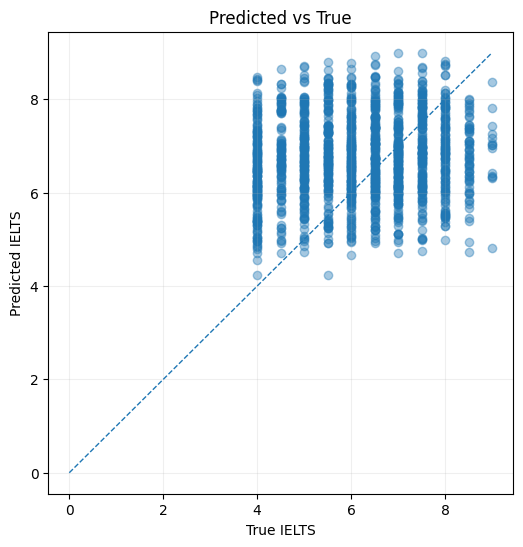

In [15]:
# Cell 7 - scatter predicted vs true
plt.figure(figsize=(6,6))
plt.scatter(y_true_ielts, y_pred_ielts, alpha=0.4)
plt.plot([0,9],[0,9], '--', linewidth=1)
plt.xlabel("True IELTS")
plt.ylabel("Predicted IELTS")
plt.title("Predicted vs True")
plt.grid(alpha=0.2)
plt.show()


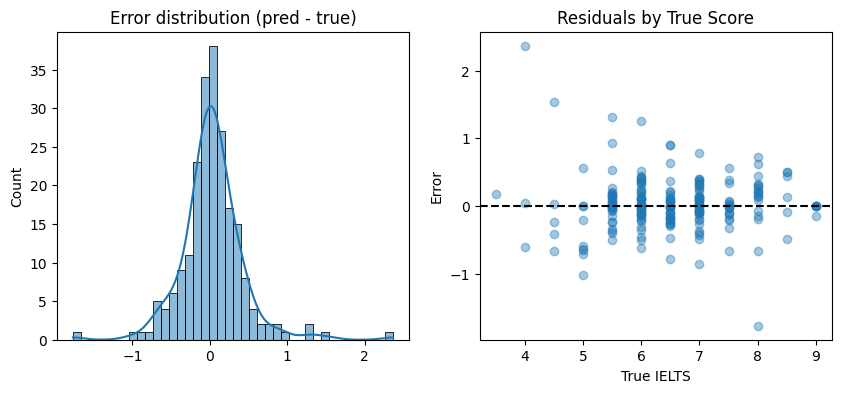

In [17]:
# Cell 8 - residuals / histogram
errors = y_pred_ielts - y_true_ielts
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(errors, bins=40, kde=True)
plt.title("Error distribution (pred - true)")

plt.subplot(1,2,2)
plt.scatter(y_true_ielts, errors, alpha=0.4)
plt.axhline(0, color='k', linestyle='--')
plt.xlabel("True IELTS")
plt.ylabel("Error")
plt.title("Residuals by True Score")
plt.show()


In [16]:
# Cell 9 - per-band average error & counts
bands = sorted(set(y_true_ielts))
avg_errors = []
counts = []
for b in bands:
    mask = y_true_ielts == b
    avg_errors.append(np.mean(np.abs(errors[mask])))
    counts.append(np.sum(mask))

fig, ax1 = plt.subplots(figsize=(10,4))
ax2 = ax1.twinx()
ax1.bar(bands, avg_errors, alpha=0.7, label='avg abs error (bands)')
ax2.plot(bands, counts, color='orange', marker='o', label='count')
ax1.set_xlabel("Band")
ax1.set_ylabel("Avg abs error")
ax2.set_ylabel("Count")
ax1.set_title("Per-band avg absolute error and counts")
ax1.legend(loc='upper left'); ax2.legend(loc='upper right')
plt.show()


NameError: name 'errors' is not defined

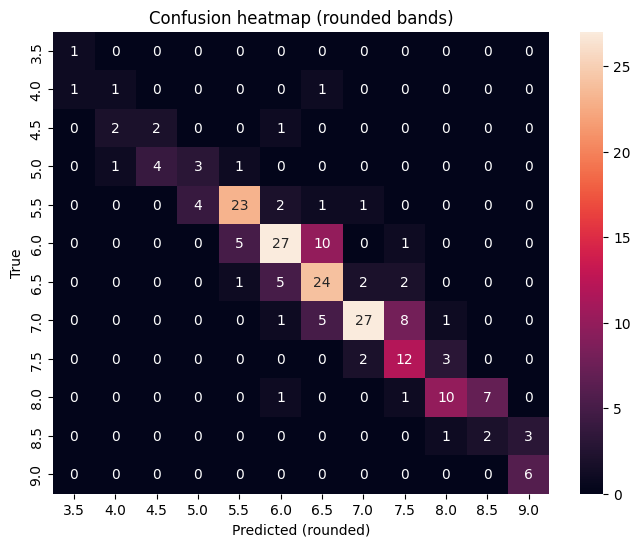

In [21]:
# Cell 10 - confusion heatmap (rounded to 0.5 bands)
y_pred_round = np.round(y_pred_ielts * 2)/2
unique_bands = sorted(list(set(np.concatenate([y_true_ielts, y_pred_round]))))
cm = confusion_matrix(
    y_true_ielts.astype(str),
    y_pred_round.astype(str),
    labels=[str(b) for b in unique_bands]
)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=unique_bands, yticklabels=unique_bands)
plt.xlabel("Predicted (rounded)")
plt.ylabel("True")
plt.title("Confusion heatmap (rounded bands)")
plt.show()


In [17]:
# Cell 11 - bootstrap CI function and display
def bootstrap_metric(y_true, y_pred, metric_fn, n_bootstrap=1000):
    rng = np.random.default_rng(42)
    metrics = []
    n = len(y_true)
    for _ in range(n_bootstrap):
        idx = rng.integers(0, n, n)
        metrics.append(metric_fn(y_true[idx], y_pred[idx]))
    return np.percentile(metrics, 2.5), np.percentile(metrics, 97.5)

mae_ci = bootstrap_metric(y_true_ielts, y_pred_ielts, mean_absolute_error, 1000)
r2_ci = bootstrap_metric(y_true_ielts, y_pred_ielts, r2_score, 1000)
print("MAE CI:", mae_ci, "R2 CI:", r2_ci)


MAE CI: (1.2909499260773094, 1.3874159801935746) R2 CI: (-0.6079795691288228, -0.4228361462517961)


In [3]:
from datasets import load_dataset

# If it is on the Hub under name "chillies/IELTS‑writing‑task‑2‑evaluation"
ds = load_dataset("chillies/IELTS-writing-task-2-evaluation")
# Inspect it
print(ds["train"].features)
print(ds["train"][0])

# If you want it as a pandas DataFrame:
import pandas as pd
df_train = pd.DataFrame(ds["train"])

# Then you can proceed with your model predictions etc.


Generating test split: 100%|██████████| 491/491 [00:00<00:00, 21202.98 examples/s]


{'prompt': Value('string'), 'essay': Value('string'), 'evaluation': Value('string'), 'band': Value('string')}
{'prompt': 'Interviews form the basic criteria for most large companies. However, some people think that the interview is not a reliable method of choosing whom to employ and there are other better methods. To what extent do you agree or disagree?', 'essay': 'It is believed by some experts that the traditional approach of recruiting candidates which is interviewing is the best way, whereas others think different methods such as exams writing, CVs, cover letters or application letters and many more are good. I strongly agree with the statement, "interview is the most reliable approach to recruit workers" because this method assists the recruiters to know the person and his ability to do the work and their problem-solving abilities. \n\nTo begin with, an interview enables the  recruiter to know the kind of person he or she is recruiting. It helps the employer to see the personali